# ConvGRU Demo Notebook

This notebook demonstrates the usage of ConvGRU (Convolutional Gated Recurrent Unit) implementation. ConvGRU is particularly useful for processing spatiotemporal data where both spatial and temporal dependencies need to be captured.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from convgru import ConvGRU

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 1. Creating a ConvGRU Model

Let's create a ConvGRU model with multiple layers. Each layer can have different hidden sizes and kernel sizes.

In [2]:
# Model parameters
input_channels = 1  # number of input channels
hidden_channels = [32, 64, 32]  # number of channels in each layer
kernel_sizes = [3, 5, 3]  # kernel size for each layer
n_layers = 3

# Create the model
model = ConvGRU(
    input_size=input_channels,
    hidden_sizes=hidden_channels,
    kernel_sizes=kernel_sizes,
    n_layers=n_layers
)
"""
The nn.init.orthogonal and nn.init.constant have been marked as obsolete (deprecated) ,
and a new function nn.init.orthogonal is recommended_ And nn.init.constant_ To replace.
"""

print(f"Model architecture:\n{model}")

D:\code_Python\pytorch_convgru\convgru.py:22: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  init.orthogonal(self.reset_gate.weight)
D:\code_Python\pytorch_convgru\convgru.py:23: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  init.orthogonal(self.update_gate.weight)
D:\code_Python\pytorch_convgru\convgru.py:24: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  init.orthogonal(self.out_gate.weight)
D:\code_Python\pytorch_convgru\convgru.py:25: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.reset_gate.bias, 0.)
D:\code_Python\pytorch_convgru\convgru.py:26: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.update_gate.bias, 0.)
D:\code_Python\pytorch_convgru\convgru.py:27: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.out_gat

Model architecture:
ConvGRU(
  (ConvGRUCell_00): ConvGRUCell(
    (reset_gate): Conv2d(33, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (update_gate): Conv2d(33, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (out_gate): Conv2d(33, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (ConvGRUCell_01): ConvGRUCell(
    (reset_gate): Conv2d(96, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (update_gate): Conv2d(96, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (out_gate): Conv2d(96, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (ConvGRUCell_02): ConvGRUCell(
    (reset_gate): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (update_gate): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (out_gate): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


## 2. Creating Sample Data

Let's create a simple moving circle animation as our input data to demonstrate how ConvGRU processes spatiotemporal data.

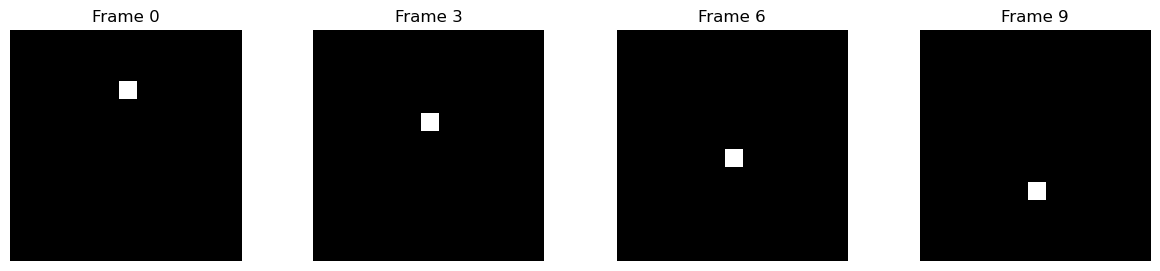

In [3]:
def create_moving_circle(frames=10, size=64, radius=3):
    """Create a sequence of frames with a moving circle."""
    sequence = np.zeros((frames, size, size))
    center_x = size // 4
    center_y = size // 2
    
    for t in range(frames):
        # Update circle position
        x = center_x + int(t * size/(2*frames))
        y = center_y
        
        # Create meshgrid for the frame
        xx, yy = np.mgrid[:size, :size]
        circle = (xx - x) ** 2 + (yy - y) ** 2
        sequence[t] = (circle < radius ** 2).astype(float)
    
    return sequence

# Create sample sequence
sequence = create_moving_circle()

# Visualize a few frames
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(sequence[i*3], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Frame {i*3}')
plt.show()

## 3. Processing Data with ConvGRU

Now let's process our sequence data with the ConvGRU model.

In [4]:
# Convert sequence to PyTorch tensor
sequence_tensor = torch.FloatTensor(sequence)
# Add batch and channel dimensions [batch, channel, time, height, width]
sequence_tensor = sequence_tensor.unsqueeze(0).unsqueeze(0)
print(f"Input tensor shape: {sequence_tensor.shape}")

# Process each frame through the ConvGRU
outputs = []
hidden = None

for t in range(sequence_tensor.size(2)):
    # Get current frame [batch, channel, height, width]
    current_frame = sequence_tensor[:, :, t, :, :]
    # Process through ConvGRU
    hidden = model(current_frame, hidden)
    # Store output from last layer
    outputs.append(hidden[-1].detach().numpy())

outputs = np.array(outputs)
print(f"Output sequence shape: {outputs.shape}")

Input tensor shape: torch.Size([1, 1, 10, 64, 64])
Output sequence shape: (10, 1, 32, 64, 64)


## 4. Visualizing the Results

Let's visualize some feature maps from the output to see what the ConvGRU has learned.

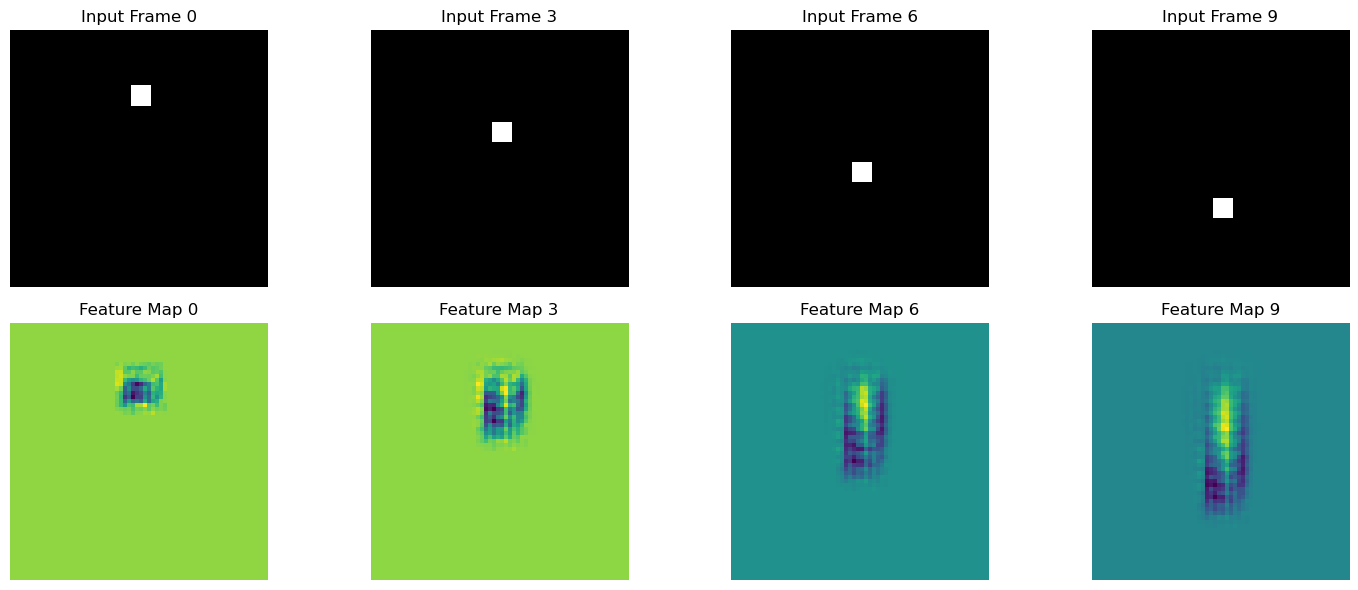

In [5]:
# Visualize some feature maps from the last layer
feature_idx = 0  # Index of feature map to visualize
fig, axes = plt.subplots(2, 4, figsize=(15, 6))

# Plot input frames
for i, ax in enumerate(axes[0]):
    frame_idx = i * 3
    ax.imshow(sequence[frame_idx], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Input Frame {frame_idx}')

# Plot corresponding feature maps
for i, ax in enumerate(axes[1]):
    frame_idx = i * 3
    ax.imshow(outputs[frame_idx, 0, feature_idx], cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Feature Map {frame_idx}')

plt.tight_layout()
plt.show()

## 5. Training Example

Here's a simple example of how to train the ConvGRU model on a sequence prediction task.

In [6]:
# Create a simple sequence prediction task
class SequencePredictor(nn.Module):
    def __init__(self, convgru_model):
        super().__init__()
        self.convgru = convgru_model
        self.output_conv = nn.Conv2d(hidden_channels[-1], 1, kernel_size=1)
    
    def forward(self, x, hidden=None):
        # Process through ConvGRU
        hidden = self.convgru(x, hidden)
        # Use last layer's output
        out = self.output_conv(hidden[-1])
        return out, hidden

# Create predictor model
predictor = SequencePredictor(model)

# Training parameters
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(predictor.parameters(), lr=0.001)

# Training loop example (just a few iterations for demonstration)
for epoch in range(5):
    optimizer.zero_grad()
    
    # Get current frame and next frame as target
    for t in range(sequence_tensor.size(2)-1):
        current_frame = sequence_tensor[:, :, t, :, :]
        target_frame = sequence_tensor[:, :, t+1, :, :]
        
        # Forward pass
        output, hidden = predictor(current_frame)
        loss = criterion(output, target_frame)
        
        # Backward pass
        loss.backward(retain_graph=True)
    
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

Epoch 1, Loss: 0.035889
Epoch 2, Loss: 0.034424
Epoch 3, Loss: 0.032627
Epoch 4, Loss: 0.030245
Epoch 5, Loss: 0.027177


This demonstration shows how to:
1. Create and initialize a ConvGRU model
2. Prepare and process sequential data
3. Visualize the inputs and feature maps
4. Set up a training loop for sequence prediction

The ConvGRU can be used for various spatiotemporal tasks such as:
- Weather prediction
- Video frame prediction
- Satellite image analysis
- Traffic flow prediction